# Part3

In [1]:
import numpy as np
import random
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
N_WORLD_FEATURES = 5  #the temporal context model assumes that the past becomes increasingly
N_ITEMS = 10          #dissimilar to the future, so that memories become harder to retrieve the
ENCODING_TIME = 500   #farther away in the past they are
TEST_TIME = 20

In [3]:
schedule =np.column_stack((np.sort(np.round(np.random.random(N_ITEMS)*500)),np.arange(N_ITEMS)))
schedule_load = ENCODING_TIME/np.median(np.diff(schedule[:,0]))
encoding = np.zeros((N_ITEMS,N_WORLD_FEATURES+1))
schedule_load

19.23076923076923

In [4]:
def generatemixgaussian():
#     numpy.random.seed(0x5eed)
    mean=[0,1]
    var=0.2
    y=list()
    for i in range(10000):
        sample=np.random.choice(2,1,p=[0.5,0.5])
        y.append(stats.norm.rvs(mean[sample[0]],var))
    y=np.array(y)
    x_eval = np.linspace(y.min(), y.max(), 400)
    bimodal_pdf = stats.norm.pdf(x_eval, loc=mean[0], scale=var)*0.5 + stats.norm.pdf(x_eval, loc=mean[1], scale=var) *0.5
    plt.plot(x_eval, bimodal_pdf, 'r--', label="Actual PDF")
    plt.hist(y, density=True, bins=20)
    plt.title("small mean: 0;large mean 1;var in both=0.2")
    plt.savefig('mixgaussian.png',bbox='tight')
    plt.show()
    return np.array(y)

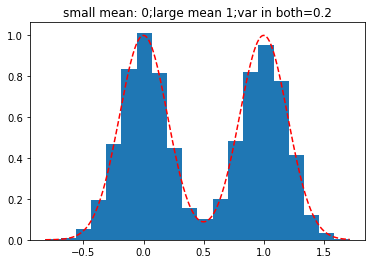

In [5]:
mixmodel=generatemixgaussian()

In [6]:
world_m = np.array([1 ,2 ,1, 2, 3])          
world_var = 1
delta = np.random.choice(mixmodel)                
beta_param = 0.001      #context drift parameter, ct=beta*ct + c_t-1      
m = 0

In [7]:
def drawFromADist(p):
    if(np.sum(p)==0):
        p = 0.05*np.ones(len(p))
    p=p/np.sum(p)
    c=np.cumsum(p)
    idx=np.where((np.random.random(1)-np.cumsum(p))<0)
    sample=np.min(idx)
    out = np.zeros(len(p))
    out[sample] = 1
#     out[out==0] = 0.1
    return out

#### Simulation encoding

In [8]:
saved_delta=list()
for time in range(ENCODING_TIME):
    world_m = world_m + delta
    #world_m = beta_param*world_m + delta
    world = np.random.normal(world_m, world_var)
    delta=np.random.choice(mixmodel)
    saved_delta.append(delta)
    if(m<N_ITEMS):
        if(time==schedule[m,0]):
            encoding[m,0:5] =  world
            encoding[m,5]=m     #encoding world context and item
            m =  m + 1
saved_delta=np.array(saved_delta)

## Expectation maximization to learn the drift distribution parameters
#### Learnt distribution will be used during retrieval period

In [9]:
from sklearn.mixture import GaussianMixture
newgaussianmodel = GaussianMixture(n_components = 2, tol=0.000001) # since we know bimodal distribution
newgaussianmodel.fit(np.expand_dims(saved_delta, 1))               # Parameters: 1 dimension dataset so 1 feature

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=1e-06, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [10]:
print("Means are :",newgaussianmodel.means_)
# now we sample from learned model

Means are : [[0.00150467]
 [1.00992007]]


#### Simulating retrieval using SAM, but with a bijective image-item mapping

In [11]:
out=np.zeros(TEST_TIME)
while(time<ENCODING_TIME+TEST_TIME):
    delta=np.random.choice(newgaussianmodel.sample()[0][0])
    world_m = world_m + delta
#     world_m = beta_param*world_m + delta
    world = np.random.normal(world_m, world_var)
    soa=np.zeros(N_ITEMS)
    temp=np.zeros(N_WORLD_FEATURES+1)
    for m in range(N_ITEMS):
        temp[0:5] =  world
        temp[5]=m
        soa[m]=np.dot(encoding[m,0:-1],temp[0:-1].T)     
    soa=soa/np.linalg.norm(soa)
    out[time-ENCODING_TIME] = np.where(drawFromADist(soa)>0)[0]
    time = time + 1

In [12]:
success=len(np.unique(out))
print("Success is {} with scheduling load {}".format(success,schedule_load))

Success is 9 with scheduling load 19.23076923076923


### Over multiple trial with previous question optimal scheduling policy

In [13]:
def model(schedule):
    N_WORLD_FEATURES = 5
    N_ITEMS = 10
    ENCODING_TIME = 500
    TEST_TIME = 20
    schedule_load = ENCODING_TIME/np.median(np.diff(schedule[:,0]))
    encoding = np.zeros((N_ITEMS,N_WORLD_FEATURES+1))
    
    
    world_m = np.array([1 ,2 ,1, 2, 3])          
    world_var = 1
    delta = np.random.choice(mixmodel)                  
    beta_param = 0.001      #context drift parameter, ct=beta*ct + c_t-1      
    m = 0
    
    #########encoding########################################
    saved_delta=list()
    for time in range(1,ENCODING_TIME):
        world_m = world_m + delta
        world_m = beta_param*world_m + delta
        world = np.random.normal(world_m, world_var)
        delta=np.random.choice(mixmodel)
        saved_delta.append(delta)
        if(m<N_ITEMS):
            if(time==schedule[m,0]):
                encoding[m,0:5] =  world
                encoding[m,5]=m     #encoding world context and item
                m =  m + 1
    saved_delta=np.array(saved_delta)
    
    #####################################Expectation Maximization Step#####################
    from sklearn.mixture import GaussianMixture
    newgaussianmodel = GaussianMixture(n_components = 2, tol=0.000001) # since we know bimodal distribution
    newgaussianmodel.fit(np.expand_dims(saved_delta, 1))  
    
    
     
    ########################################retrieval##########################
    out=np.zeros(TEST_TIME)
    while(time<ENCODING_TIME+TEST_TIME):
        delta=np.random.choice(newgaussianmodel.sample()[0][0])
        world_m = world_m + delta
        world_m = beta_param*world_m + delta
        world = np.random.normal(world_m, world_var)
        soa=np.zeros(N_ITEMS)
        temp=np.zeros(N_WORLD_FEATURES+1)
        for m in range(N_ITEMS):
            temp[0:5] =  world
            temp[5]=m
            soa[m]=np.dot(encoding[m,0:-1],temp[0:-1].T)     
        soa=soa/np.linalg.norm(soa)
        out[time-ENCODING_TIME] = np.where(drawFromADist(soa)>0)[0]
        time = time + 1
    return len(np.unique(out)),schedule_load

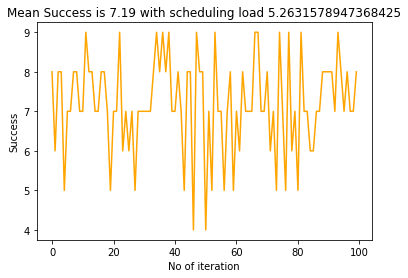

[[  1   0]
 [100   1]
 [200   2]
 [300   3]
 [400   4]
 [495   5]
 [496   6]
 [497   7]
 [498   8]
 [499   9]]


In [14]:
g=[1, 100, 200, 300, 400, 495, 496, 497, 498,499]  
schedule =np.column_stack((np.sort(g),np.arange(N_ITEMS)))
schedule_load = ENCODING_TIME/np.median(np.diff(schedule[:,0]))
np.random.seed(47)
x=[model(schedule) for i in range(100)]
x=np.array(x)
plt.plot(np.arange(100),x[:,0],c='orange')
plt.ylabel('Success')
plt.xlabel('No of iteration')
plt.title('Mean Success is '+str(np.mean(x[:,0]))+" with scheduling load "+str(schedule_load))
plt.savefig('With_learned_parameter',bbox='tight')
plt.show()
print(schedule)

In [15]:
######################END############################################################################################